In [68]:
import math
import pathlib

import joblib
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import itertools
import time

import yaml
from safetensors import numpy as safetensors

## Preprocessed dataset

| **Subset** | **Tile** | **# Samples** | **Resolution** |
|:-----------|:--------:|:-------------:|:--------------:|
| Training   |  T30TYQ  |  15941        |    256x256   |
| Validation |  T30TYR  |  ❓           |    256x256     |

> CESBIO - Centre d'études spatiales de la biosphère. Unlabeled Sentinel 2 time series dataset (training: T30TYQ, validation: T30TYR). Zenodo, 2023. Available at: https://zenodo.org/records/7890542. Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/.

In [69]:
root_path = pathlib.Path("/p/scratch/training2504/maurogiovanni1/data/s2l2a-patches")
folder_path = root_path / "train"
sample_name = "SENTINEL2B_20201121-105848-055_patch_8_subpatch_14-of-16.safetensors"
# sample_name = "SENTINEL2A_20190824-105849-440_patch_9_subpatch_04-of-16.safetensors"
sample_path = folder_path / sample_name

In [70]:
total_num_samples = len(list(folder_path.iterdir()))
assert total_num_samples == 15941
print("👍")

👍


In [71]:
data = safetensors.load_file(sample_path)["data"]
assert data.dtype == np.int16
print("👍")

👍


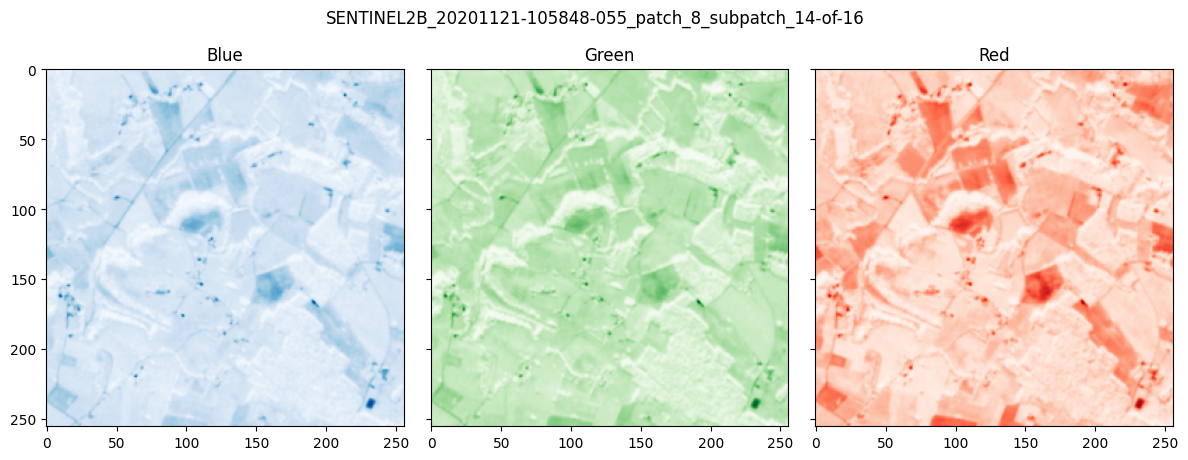

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharey=True)
cmaps = ["Blues", "Greens", "Reds"]
for idx, cmap in enumerate(cmaps):
    axes[idx].imshow(data[idx], cmap=cmap)
    axes[idx].set_title(cmap[:-1])

fig.suptitle(str(sample_path.stem))
fig.tight_layout()
fig.subplots_adjust(top=1.55)

plt.show()

In [73]:
batch_size = 200
num_batches = math.ceil(total_num_samples / batch_size)

In [74]:
def load_batch(batch):
    return np.stack([safetensors.load_file(sample)["data"] for sample in batch])

In [75]:
def local_stats(data):
    means = data.mean(axis=(0, -2, -1), keepdims=True)
    sum_of_squares = np.square(data - means).sum(axis=(0, -2, -1))
    sum_of_values = data.sum(axis=(0, -2, -1))

    return sum_of_values, sum_of_squares

In [76]:
def stats_pipeline(batch):
    return np.column_stack(local_stats(load_batch(batch)))

In [77]:
samples_loader = itertools.batched(folder_path.iterdir(), n=batch_size)
start = time.time()
seq_stats_array = [stats_pipeline(batch) for batch in samples_loader]
end = time.time()
seq_all_stats = np.stack(seq_stats_array, axis=1)
print(f"Took {end - start:.1f}s to compute stats over {num_batches} batches.")

Took 63.1s to compute stats over 80 batches.


In [78]:
samples_loader = itertools.batched(folder_path.iterdir(), n=batch_size)
start = time.time()
par_stats_array = joblib.Parallel(n_jobs=16, timeout=9999)(
    joblib.delayed(stats_pipeline)(batch) for batch in samples_loader
)
end = time.time()
par_all_stats = np.stack(par_stats_array, axis=1)
print(f"Took {end - start:.1f}s to compute stats over {num_batches} batches.")

Took 6.1s to compute stats over 80 batches.


In [79]:
assert np.allclose(seq_all_stats, par_all_stats)
print("👍")

👍


In [80]:
global_stats = par_all_stats.sum(axis=1)

In [81]:
global_sum, global_sos = global_stats[:, 0], global_stats[:, 1]
global_num_pixels = total_num_samples * data.size

In [88]:
stats = {
    "num_samples": total_num_samples,
    "mean": (global_sum / global_num_pixels).tolist(),
    "sum_of_squares": global_sos.tolist(),
    "std": np.sqrt(global_sos / (global_num_pixels - 1)).tolist(),
}

In [90]:
with open(root_path / "statistics.yml", mode="w") as file:
    yaml.dump(stats, file)